In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

c:\Users\mrmoh\anaconda3\envs\Nerf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
c2w1 = np.array([0.34303784370422363,
                 -0.8594792485237122,
                 0.3789729177951813,
                 3.7897279262542725,
                 0.9393215775489807,
                 0.3138796091079712,
                 -0.13839992880821228,
                 -1.3840025663375854,
                 0.0,
                 0.40345385670661926,
                 0.9150000214576721,
                 9.149999618530273,
                 0.0,
                 0.0,
                 0.0,
                 1.0])
c2w1 = c2w1.reshape((4, 4))


c2w2 = np.array([-0.7053813934326172,
                -0.5776947736740112,
                0.41073814034461975,
                4.1073899269104,
                0.7088279724121094,
                -0.5748858451843262,
                0.4087409973144531,
                4.087401390075684,
                0.0,
                0.5794609785079956,
                0.8149999976158142,
                8.149999618530273,
                0.0,
                0.0,
                0.0,
                1.0])
c2w2 = c2w2.reshape((4, 4))

In [5]:
H = 400
W = 400
f = 1200


In [6]:
c2w1.shape

(4, 4)

In [ ]:
c2w = c2w1

rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)

dirs = c2w @ dirs

rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

rays_o += c2w[:3, 3]

In [8]:
c2w = c2w2

rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)

dirs = (c2w[:3, :3] @ dirs[..., None])

rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

rays_o += c2w[:3, 3]

In [9]:
dirs.shape

(400, 400, 3, 1)

In [ ]:
c2w = c2w2
# this is for single dimension rays
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)

dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)

rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

rays_o += c2w[:3, 3]

In [11]:
dirs.shape

(400, 400, 3)

In [12]:
def plot_rays(o, d, t):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    
    for p1, p2 in zip(pt1[::100], pt2[::100]):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    plt.show()

c:\Users\mrmoh\anaconda3\envs\Nerf\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  after removing the cwd from sys.path.


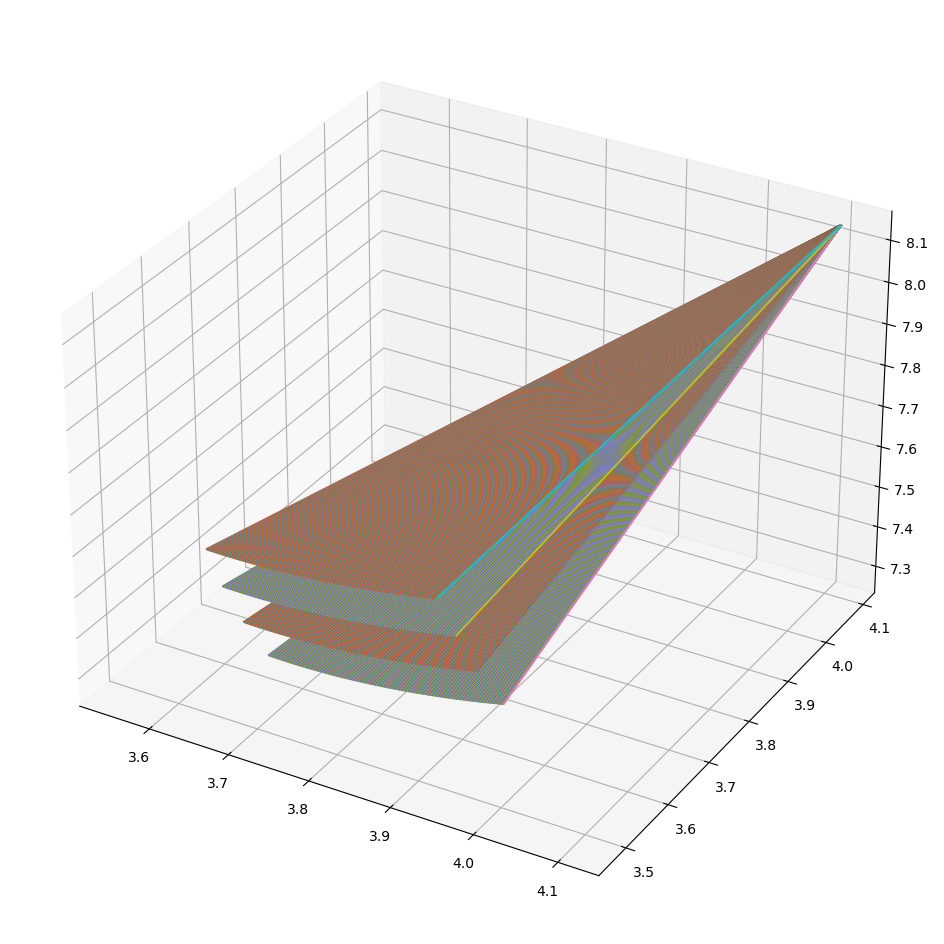

In [15]:
plot_rays(rays_o, rays_d, 1)

In [16]:
class Sphere():
    
    def __init__(self, p, r, c):
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        
        # (x- xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2 
        
        cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 <= self.r**2
                
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[cond] = self.c
        density[cond] = 10
        
        color_condition = x[:, 0] < 0
        tmp = colors[color_condition, 0].clone()
        colors[color_condition, 0] = colors[color_condition, 1].clone()
        colors[color_condition, 1] = tmp
        
        return colors, density

In [17]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1) 
    accumulated_transmittance[:, 0] = 1.
    return accumulated_transmittance

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu'):
    
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))
    
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]
    
    colors, density = model.intersect(x.reshape(-1, 3))
    
    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))
    
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # [nb_rays, nb_bins, 1]

    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    
    return c

In [41]:
model = Sphere(torch.tensor([0, 0, 0]), 1, torch.tensor([1., 0., 0.]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 8, 12)

In [42]:
img = px_colors.reshape(H, W, 3).cpu().numpy()

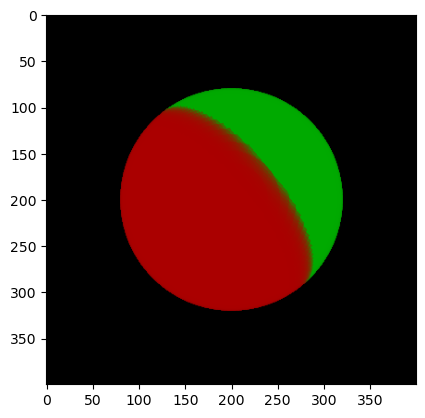

In [43]:
plt.figure(dpi=100)
plt.imshow(img)

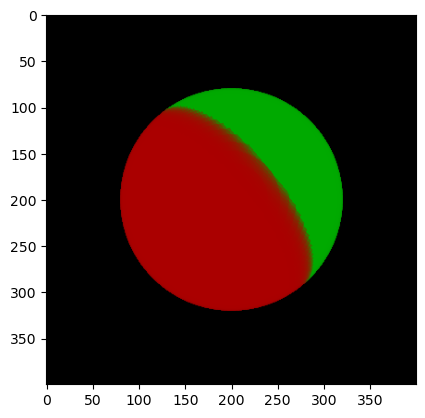

In [44]:
plt.figure(dpi=100)
plt.imshow(img)